# Mapping with cartopy - P3 - SEA4001W
## Ethan Smith -SMTETH005- 13 March 2025 

In [1]:
# Import necessary packages
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib
import requests
import io
import zipfile
from glob import glob
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import time
import rasterio
from rasterio.plot import show, reshape_as_image

# Initialize the geolocator
geolocator = Nominatim(user_agent='educational')  # Nominatim requires a useragent

## Section 1 - Antarctica and the Southern Ocean to 60 degrees south.

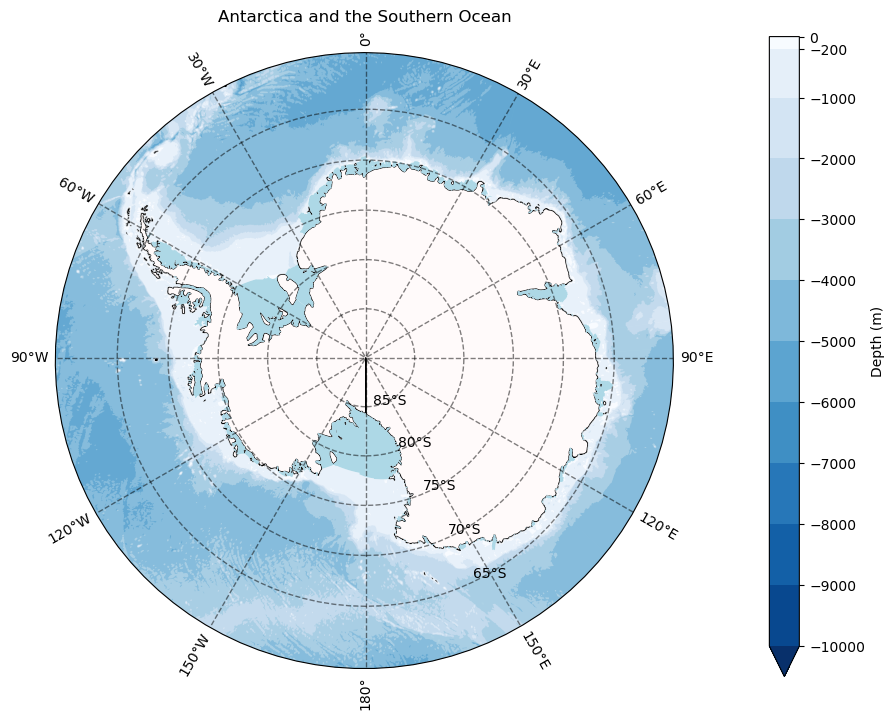

In [2]:
def load_bathymetry(zip_file_url):
    """Download and extract bathymetry shapefiles"""
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("ne_10m_bathymetry_all/")

    # Read and sort shapefiles by depth
    shp_dict = {}
    files = glob('ne_10m_bathymetry_all/*.shp')
    assert len(files) > 0, "No shapefiles found!"
    files.sort()
    
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # Extract depth from filename
        depths.append(depth)
        nei = shpreader.Reader(f)  # No bbox filtering here; apply filter later
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # Sort from shallow to deep
    return depths, shp_dict

# Load bathymetry data
depths_str, shp_dict = load_bathymetry(
    'https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_bathymetry_all.zip'
)

# Define colormap
depths = depths_str.astype(int)
N = len(depths)
nudge = 0.01
boundaries = [min(depths)] + sorted(depths + nudge)
norm = matplotlib.colors.BoundaryNorm(boundaries, N)
blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
colors_depths = blues_cm(norm(depths))

# Set up plot with South Polar Stereographic projection
fig = plt.figure(figsize=(12, 8), dpi = 100)
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -59], crs=ccrs.PlateCarree())

# Plot bathymetry layers
for i, depth_str in enumerate(depths_str):
    for geom in shp_dict[depth_str].geometries():
        # Transform the bathymetry geometries before adding them
        ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor=colors_depths[i], edgecolor='none', alpha=0.8)

# Add land and ocean features
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '10m', edgecolor='None', facecolor = 'lightblue'))
ax.add_feature(cfeature.LAND, facecolor='snow', edgecolor='black', linewidth=1)
ax.add_feature(cfeature.GSHHSFeature(scale='f'))  # High-resolution coastline

# Add latitude and longitude gridlines
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, xlocs=range(-180, 171, 30), ylocs=range(-90, -61, 5), color='k', alpha=0.5, linestyle='--')

# Add circular boundary
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add custom colorbar
axi = fig.add_axes([0.85, 0.1, 0.025, 0.8])
sm = plt.cm.ScalarMappable(cmap=blues_cm, norm=norm)
fig.colorbar(mappable=sm, cax=axi, spacing='proportional', extend='min', ticks=depths, label='Depth (m)')

# Add title
ax.set_title('Antarctica and the Southern Ocean')

# Render the plot
plt.show()

Here is a map of the Antarctic continent and the bathymetry of the Southern Ocean from the south pole to 60 degrees south. I have added [bathymetry](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-bathymetry/) and [ice shelves](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-antarctic-ice-shelves/) to the plot. I chose a *stereographic* projection centered on the south pole. It is conformal, meaning that it preserves angles at which curves meet and as a result it somewhat preserves shape. This projection does not preserve distance nor area. I feel like it is an appropriate choice to illustrate the shape of Antarctica, since other projections often distort or dismantle the shape thereof. 

## Section 2 - The South Atlantic, from 20°S to 50°S.

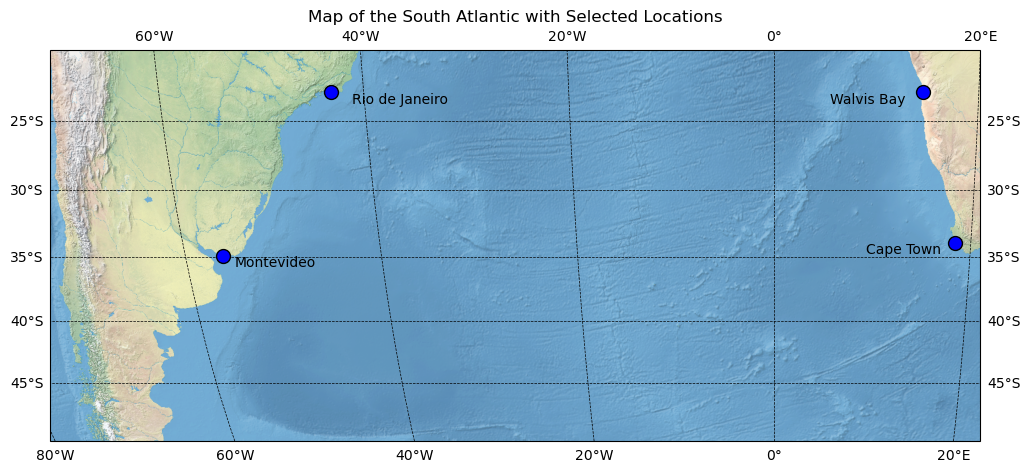

In [3]:
# Define map extent
extent = [-70, 20, -50, -20]  # (lon_min, lon_max, lat_min, lat_max)
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Define locations
places = ['Walvis Bay', 'Cape Town', 'Rio de Janeiro', 'Montevideo']

# Get addresses (store only longitude, latitude, name)
addresses = []
for p in places:
    try:
        loc = geolocator.geocode(p, language="en")
        if loc and loc.longitude and loc.latitude:
            addresses.append((loc.longitude, loc.latitude, p))  # Store as tuple (lon, lat, name)
        else:
            print(f"Skipping location (not found): {p}")
    except Exception as e:
        print(f"Error retrieving {p}: {e}")
    time.sleep(1)  # Avoid rate limits

# Load raster image
raster_path = r"C:\Users\ethan\Ethans's Jupyter stuff\SMTETH005_Assignment_Folder\P3_cartopy_mapping\NE2_HR_LC_SR_W_DR.tif"
with rasterio.open(raster_path) as src:
    image = src.read([1, 2, 3])  # Read RGB bands
    bbox = src.bounds  # Get bounding box (left, bottom, right, top)

# Convert to proper shape
image = reshape_as_image(image)  
image = np.clip(image, 0, 255).astype(np.uint8)  # Normalize

# Plot the map
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.EckertIV())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Overlay raster image
ax.imshow(image, extent=[bbox.left, bbox.right, bbox.bottom, bbox.top], origin='upper', transform=ccrs.PlateCarree())

# Add gridlines and labels to display latitude and longitude 
ax.gridlines(draw_labels=True, color='k', linestyle='--', linewidth=0.5)

# Define offsets for each label (longitude shift, latitude shift)
label_offsets = {
    'Walvis Bay': (-9, -1),
    'Cape Town': (-9, -1),
    'Rio de Janeiro': (2, -1),
    'Montevideo': (1, -1)
}

# Plot markers and labels
for lon, lat, name in addresses:
    ax.scatter(lon, lat, color='blue', edgecolors='black', s=100, transform=ccrs.PlateCarree(), zorder=5)
    
    # Apply individual label offsets
    offset_lon, offset_lat = label_offsets[name]
    ax.text(lon + offset_lon, lat + offset_lat, name, transform=ccrs.PlateCarree(), 
            fontsize=10, color='black', ha='left', va='bottom')

plt.title("Map of the South Atlantic with Selected Locations")
plt.show()

Here is a map of the South Atlantic from 20 to 50 degrees south. I added the [Natural Earth II raster map](https://www.naturalearthdata.com/downloads/10m-raster-data/10m-natural-earth-2/) with shaded relief, water, drainages and ocean bottom. This is an idealised world environment without human interferance. I decied to use an *Eckert IV* projection, which is commonly used for world maps. This projection is equal-area, which means that other metrics such as direction and shape are not preserved that well. I want to show the size of the South Atlantic basin in relation to the west coast of South Africa and central South America, so an equal-area projection makes sense. 

## Section 3 - A series of 3 panels showing the use of different coastline resolutions from the GSHHG database in a map of False Bay.

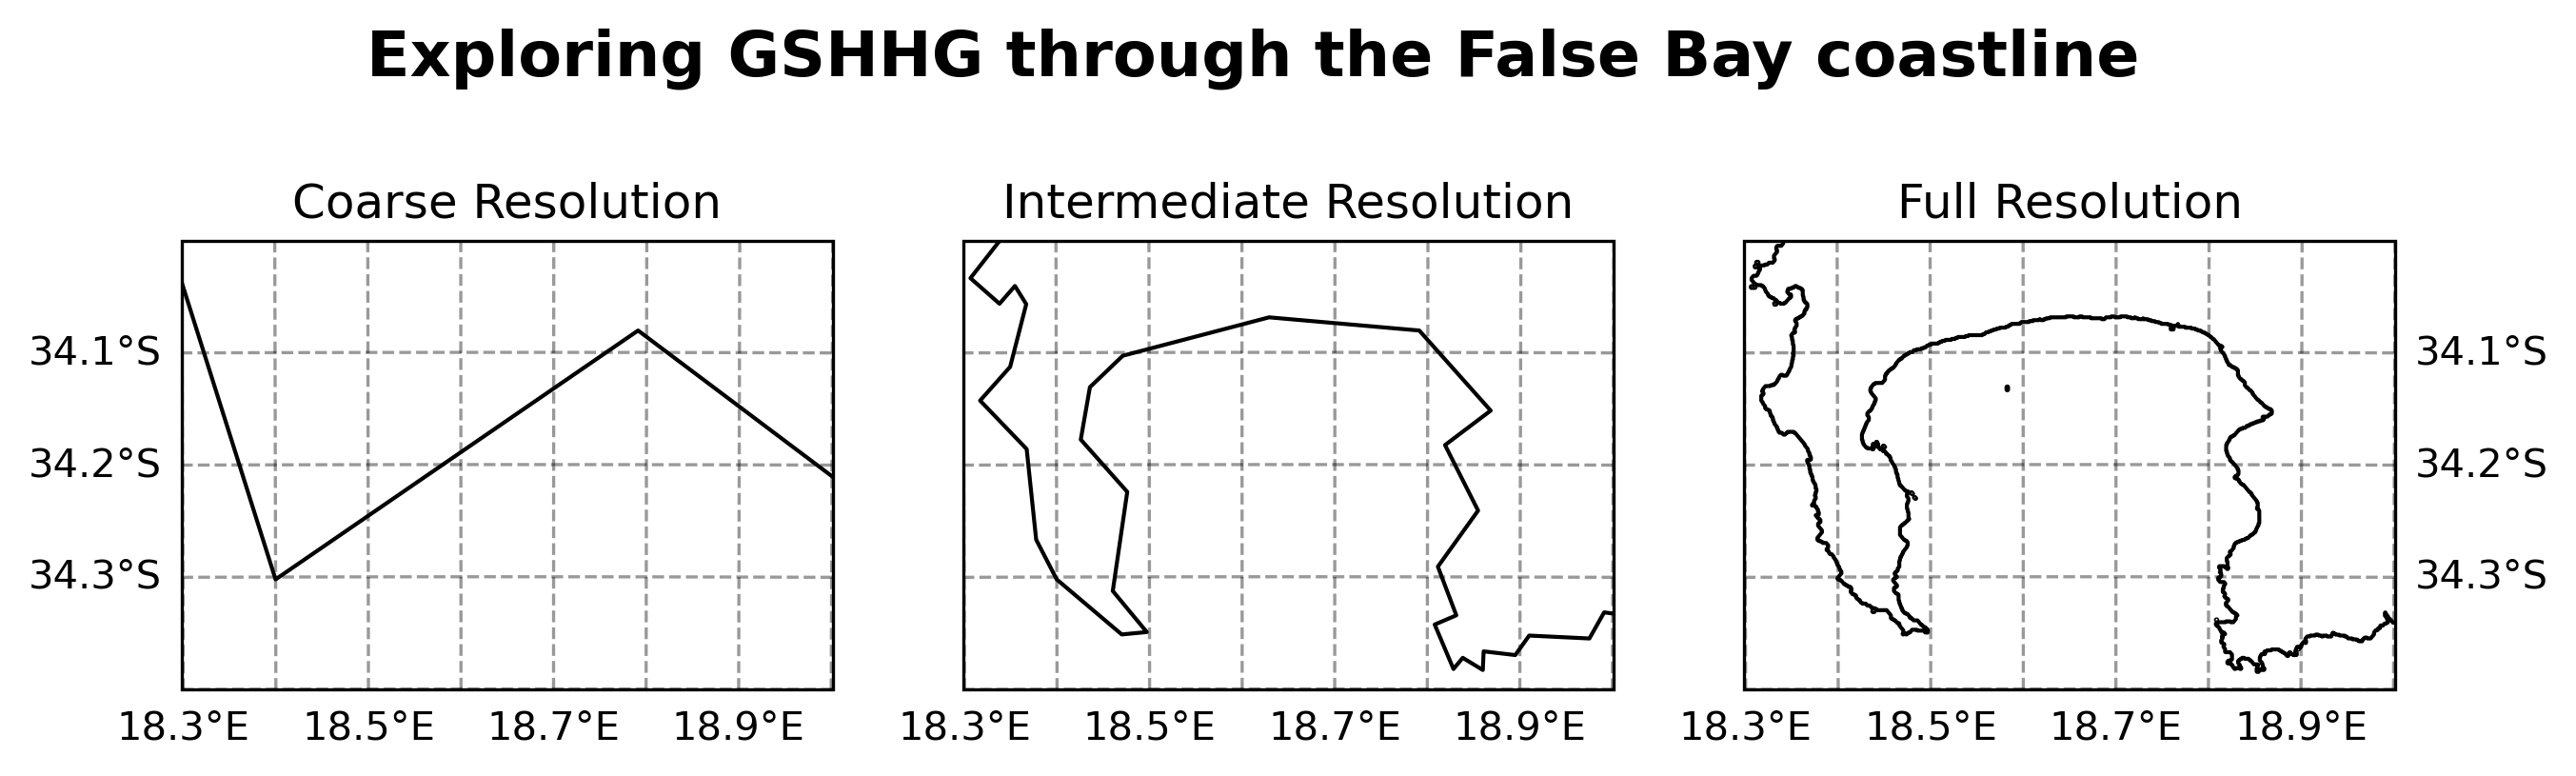

In [4]:
# Define the extent of the map
extent = [18.3, 19, -34, -34.4]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Create the three subplots in a row 
fig,ax = plt.subplots(1,3,figsize=(10,6),dpi = 300,subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

# Coarse plot
ax[0].set_extent(extent)
gl0 = ax[0].gridlines(draw_labels=True, linestyle = '--', color = 'k', alpha = 0.4)
ax[0].add_feature(cfeature.GSHHSFeature(scale='c'))
ax[0].set_title('Coarse Resolution')

# Intermediate plot
ax[1].set_extent(extent)
gl1 = ax[1].gridlines(draw_labels=True, linestyle = '--', color = 'k', alpha = 0.4)
ax[1].add_feature(cfeature.GSHHSFeature(scale='i'))
ax[1].set_title('Intermediate Resolution')

# Full plot
ax[2].set_extent(extent)
gl2 = ax[2].gridlines(draw_labels=True, linestyle = '--', color = 'k', alpha = 0.4)
ax[2].add_feature(cfeature.GSHHSFeature(scale='f'))  
ax[2].set_title('Full Resolution')

# Add an overarching title for the entire figure
plt.suptitle('Exploring GSHHG through the False Bay coastline', fontsize=16, fontweight='bold', y=0.75)

# Gridline formatting 
gl0.right_labels = False
gl0.top_labels = False
gl1.right_labels = False
gl1.left_labels = False 
gl1.top_labels = False
gl2.right_labels = True
gl2.left_labels = False
gl2.top_labels = False

Here are three plots of False Bay using the [Global Self-consistent, Hierarchical, High-resolution Geography Database](https://www.soest.hawaii.edu/pwessel/gshhg/) at varying resolutions. I decided to keep the plots simple to not draw attention away from differences in the resolutions. I decided to use an *orthographic* projection for these plots. This projection is netiher equal-area nor conformal, and thus it offers a compromise between the preservation of area and of shape. It does a good job at showing both the area on the plot and the shape of the coastline. 